In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from models.densenet import DenseNet3
import util.svhn_loader as svhn

In [2]:
transform_cifar = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

datasets = {
  'CIFAR-10': torchvision.datasets.CIFAR10(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar),
  'CIFAR-100': torchvision.datasets.CIFAR100(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar), 
  'SVHN': svhn.SVHN('datasets/ood_datasets/svhn/', split='test', transform=transform_cifar, download=False),
  'dtd': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/dtd/images", transform=transform_cifar),
  'places365': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/places365/", transform=transform_cifar),
  'celebA': torchvision.datasets.CelebA(root='datasets/ood_datasets/', split='test', download=True, transform=transform_cifar),
}

dataloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=128, shuffle=False, num_workers=2) for k,v in datasets.items()
}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(342,)

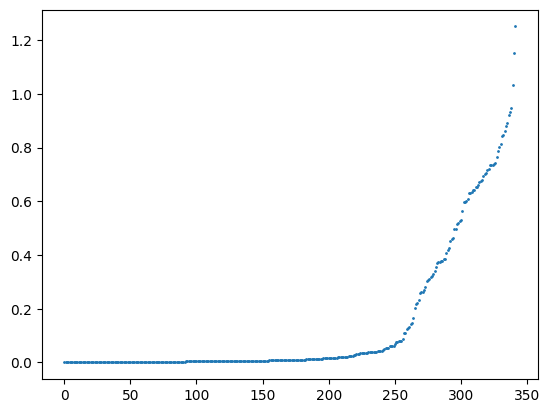

In [3]:
info = np.load(f"./cache/CIFAR-10_densenet_feat_stat.npy")
sorted_idx = np.argsort(info)
plt.scatter(range(info.shape[0]), info[sorted_idx], s=1)

info.shape

In [4]:
model = DenseNet3(100, 10, 12, reduction=0.5, bottleneck=True, dropRate=0.0, normalizer=None, p=None, info=info)
checkpoint = torch.load("./checkpoints/CIFAR-10/densenet/checkpoint_100.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.cuda();

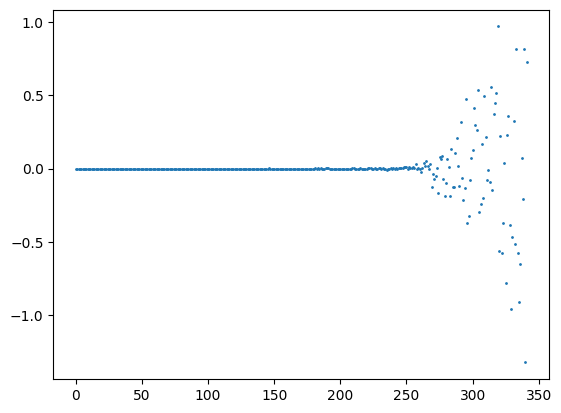

In [5]:
importance = (checkpoint['state_dict'].get('fc.weight').detach().cpu().numpy() * info)
plt.scatter(range(info.shape[0]), importance[0,sorted_idx], s=1)

In [6]:
_, eval_nodes = get_graph_node_names(model)
eval_nodes

['x',
 'conv1',
 'block1.layer.0.bn1',
 'block1.layer.0.relu',
 'block1.layer.0.conv1',
 'block1.layer.0.bn2',
 'block1.layer.0.relu_1',
 'block1.layer.0.conv2',
 'block1.layer.0.cat',
 'block1.layer.1.bn1',
 'block1.layer.1.relu',
 'block1.layer.1.conv1',
 'block1.layer.1.bn2',
 'block1.layer.1.relu_1',
 'block1.layer.1.conv2',
 'block1.layer.1.cat',
 'block1.layer.2.bn1',
 'block1.layer.2.relu',
 'block1.layer.2.conv1',
 'block1.layer.2.bn2',
 'block1.layer.2.relu_1',
 'block1.layer.2.conv2',
 'block1.layer.2.cat',
 'block1.layer.3.bn1',
 'block1.layer.3.relu',
 'block1.layer.3.conv1',
 'block1.layer.3.bn2',
 'block1.layer.3.relu_1',
 'block1.layer.3.conv2',
 'block1.layer.3.cat',
 'block1.layer.4.bn1',
 'block1.layer.4.relu',
 'block1.layer.4.conv1',
 'block1.layer.4.bn2',
 'block1.layer.4.relu_1',
 'block1.layer.4.conv2',
 'block1.layer.4.cat',
 'block1.layer.5.bn1',
 'block1.layer.5.relu',
 'block1.layer.5.conv1',
 'block1.layer.5.bn2',
 'block1.layer.5.relu_1',
 'block1.layer.5.c

In [7]:
model_aug = create_feature_extractor(model, return_nodes={'view': 'feature', 'fc':'logit'})

In [8]:
with torch.no_grad():
  feature = model_aug(torch.rand(64, 3, 32, 32, device='cuda:0'))['feature']
feature.shape

torch.Size([64, 342])

In [22]:
features = {i: [] for i in range(10)}
for x, y in tqdm(dataloaders['CIFAR-10']):
  with torch.no_grad():
    for feat, label in zip(model_aug(x.to('cuda:0'))['feature'], y):
      features[label.item()].append(feat)
features = {k: torch.stack(v).mean(dim=0) for k, v in features.items()}

  0%|          | 0/79 [00:00<?, ?it/s]

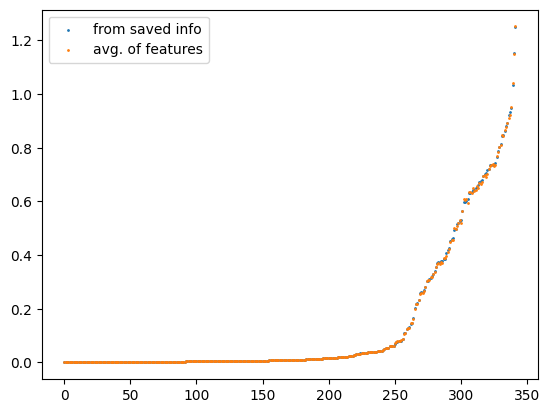

In [43]:
info2 = np.stack([features[i].cpu().numpy() for i in range(10)])
plt.scatter(range(info.shape[0]), info[sorted_idx], s=1, label='from saved info')
plt.scatter(range(info2.shape[-1]), info2.mean(axis=0)[sorted_idx], s=1, label='avg. of features')
plt.legend()


In [56]:
weight = checkpoint.get('state_dict').get('fc.weight')

contrib = torch.tensor(info, device='cuda:0') * weight
contrib2 = torch.tensor(info2, device='cuda:0') * weight

thresh = np.percentile(contrib.cpu().numpy(), 90)
thresh2 = np.percentile(contrib2.cpu().numpy(), 90)

mask = contrib > thresh
mask2 = contrib2 > thresh2

masked_weight = weight * mask
masked_weight2 = weight * mask2

masked_weight2.shape

torch.Size([10, 342])

In [57]:
checkpoint.get('state_dict')

OrderedDict([('conv1.weight',
              tensor([[[[ 3.3577e-01,  8.1818e-01,  4.4689e-01],
                        [-7.8372e-02, -1.2748e-01,  7.9255e-02],
                        [-4.2870e-01, -7.1157e-01, -3.6645e-01]],
              
                       [[ 3.4778e-01,  8.3959e-01,  4.6636e-01],
                        [-1.4282e-01, -2.0311e-01,  1.4988e-02],
                        [-3.9592e-01, -7.3452e-01, -3.7296e-01]],
              
                       [[ 2.7188e-01,  7.1080e-01,  3.9018e-01],
                        [-1.0434e-01, -1.1440e-01, -5.0457e-03],
                        [-3.0443e-01, -5.5646e-01, -3.1732e-01]]],
              
              
                      [[[ 1.5088e-01, -2.2115e-01,  4.2454e-02],
                        [-1.4128e-01, -7.9976e-01, -3.4745e-01],
                        [ 5.6563e-02, -2.4767e-01, -8.1385e-02]],
              
                       [[-1.9301e-02, -2.9059e-01,  5.8118e-02],
                        [-1.5031e-01, -7.3249

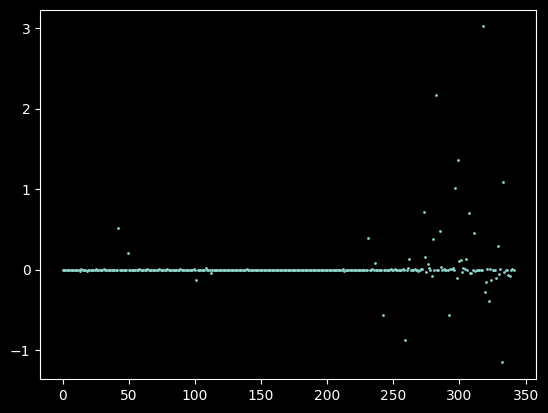

In [100]:
importance = checkpoint['state_dict'].get('fc.weight') * feature.mean(dim=0)
importance = importance.detach().cpu().numpy()
plt.scatter(range(importance.shape[-1]), importance[3], s=1)

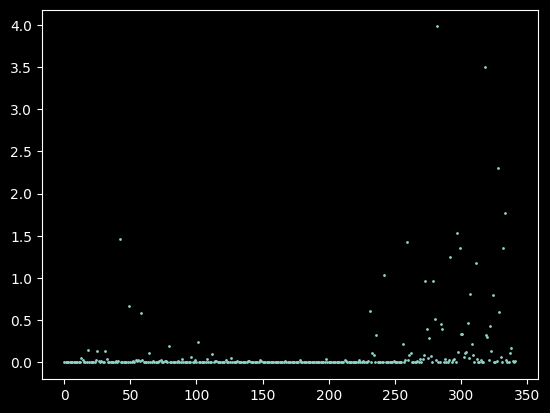